In [257]:
import numpy as np
import rasterio
from affine import Affine
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

%matplotlib inline
#%matplotlib notebook

In [273]:
fname = 'BedMachineGreenland-2017-09-20.nc' # original sampling space: 150 m

In [259]:
if (0):
    FAC = 10 # resampling factor
    tag = "1d5km" 
if (1):
    FAC = 6
    tag = "900m"

# read  netCDF

In [260]:
ds = xr.open_dataset(fname)
spacing = ds.spacing

Beware: there went something wrong with the labelling of this file!! There are two dimensions, `x` and `y`, which correspond to the "longitudinal" and "latitudinal" directions. The number of points in X is 10,218 and in Y is 18,346. However, the global attributes named `nx` and `ny` are erroneously swapped.

In [261]:
ds.dims['x'] == ds.attrs['nx'], ds.dims['y'] == ds.attrs['ny']

(False, False)

In [262]:
ds.dims['x'] == ds.attrs['ny'], ds.dims['y'] == ds.attrs['nx']

(True, True)

In [276]:
nx = ds.dims['x'] # "longitude"
ny = ds.dims['y'] # "latitude" 
xmin = ds.xmin
ymin = ds.ymax - ny * spacing # y is decreasing in Bedmachine2. We change to increasing
'origin', xmin, ymin 

('origin', -652925, -3384575)

In [264]:
ds.attrs

OrderedDict([('Conventions', 'CF-1.6'),
             ('Metadata_Conventions',
              'CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0'),
             ('title', 'BedMachine Greenland'),
             ('summary',
              'self-consistent bed/bathymetry/surface/thickness/mask dataset of the Greenland ice sheet based on mass conservation, ice penetrating radar data and bathymetry data'),
             ('keywords',
              '0720 Glaciers, 0726 Ice sheets, 0730 Ice streams, 0794 Instruments and techniques, 0798 Modeling'),
             ('keywords_vocabulary', 'AGU Index Terms'),
             ('author', 'Mathieu Morlighem'),
             ('creator_name', 'Mathieu Morlighem'),
             ('creator_email', 'mathieu.morlighem@uci.edu'),
             ('institution',
              'Department of Earth System Science, University of California Irvine'),
             ('date_created', '20-Sep-2017 09:03:04'),
             ('product_version', 'v3.10'),
             ('cdm_data_type',

# Using affine and projections to obtain lat/lon 

In [265]:
mycrs = rasterio.crs.CRS({'init': 'epsg:3413'}) # hardcoded, must be same as in NetCDF
p1 = Proj(mycrs)

In [266]:
T0 = Affine(FAC*spacing,0,xmin,0,FAC*spacing,ymin)
T0

Affine(900.0, 0.0, -652925.0,
       0.0, 900.0, -3384575.0)

In [267]:
ds['surface'].shape # ordering is y,x

(18346, 10218)

In [268]:
A = ds['surface'].values[::FAC,::FAC]
print(A.shape)

# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[1]), np.arange(A.shape[0]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)

# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)
print(lats.shape)

(3058, 1703)
(3058, 1703)


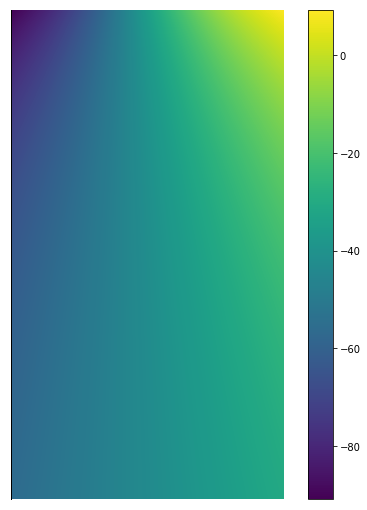

In [269]:
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection=ccrs.epsg(3413)))
img = ax.imshow(longs, origin='lower')
cb = fig.colorbar(img, ax=ax)

# Export as NetCDF

In [270]:
ds2 = xr.Dataset(
        {'topography': (['y','x'], A[::-1,:]) }, # Change y dimension from decreasing to increasing
    coords={'lon':(['y','x'], longs), 
            'lat':(['y','x'], lats)
           }
)
ds2.variables['topography'].attrs['long_name'] = "topographic height"
ds2.variables['topography'].attrs['units'] = "m"

ds2.variables['lat'].attrs['long_name'] = "latitude"
ds2.variables['lat'].attrs['units'] = "degree_north"
ds2.variables['lat'].attrs['_FillValue'] = 9.969209968386869e+36
ds2.variables['lat'].attrs['axis'] = "Y"

ds2.variables['lon'].attrs['long_name'] = "longitude"
ds2.variables['lon'].attrs['units'] = "degree_east"
ds2.variables['lon'].attrs['_FillValue'] = 9.969209968386869e+36
ds2.variables['lon'].attrs['axis'] = "X"

ds2.attrs['title'] = 'GIMP topography, converted from Bedmachine Greenland (%s)' % fname.split('/')[-1]
ds2.attrs['nx'] = str(nlon)
ds2.attrs['ny'] = str(nlat)
ds2.attrs['spacing'] = str(FAC*spacing)

# copy attributes from original
attrs_cp = 'product_version', 'cdm_data_type', 'Projection', 'proj4', 'xmin', 'ymax', 'no_data', 'license', 'Data_citation'
for attr in attrs_cp:
    ds2.attrs[attr] = ds.attrs[attr]

In [271]:
ds2.variables['topography'].encoding = {'dtype': 'float32', '_FillValue': 9.96921e+36}

In [272]:
ds2.to_netcdf('BM_%s_topo.nc' % tag)